In [1]:
import pandas as pd
import numpy as np
from PIL import Image
import cv2
from google.colab.patches import cv2_imshow
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from matplotlib import pyplot as plt


## Generate the Data Matrix and the Label vector

In [2]:
from google.colab import drive
col=list(range(0,10305))
df = pd.DataFrame(columns=col)
df_length = len(df)
df.head()

for i in range(1,41):
  for j in range(1,11):
    # Read each image
    img_name = "/content/drive/MyDrive/Datasets/FaceRecognition/s{}/{}.pgm".format(i,j)    
    img = cv2.imread(img_name,0)
    img = img.transpose()

    # Unroll image
    img = img.flatten() 
    img = np.append(img,i)
    df_length = len(df)
    df.loc[df_length] = img

In [ ]:
# Data as float
df = df.astype(float)
print(df.shape)
print(df)
df[10304] = df[10304].astype(int)
df.head()

(400, 10305)
     0      1      2      3      4      5      6      7      8      9      \
0     48.0   45.0   45.0   49.0   46.0   47.0   45.0   47.0   48.0   53.0   
1     60.0   58.0   68.0   79.0   49.0   43.0   52.0   52.0   56.0   72.0   
2     39.0   44.0   59.0   54.0   62.0   69.0   74.0   61.0   44.0   47.0   
3     63.0   56.0   52.0   40.0   43.0   43.0   29.0   30.0   30.0   24.0   
4     64.0   60.0   63.0   53.0   60.0   41.0   30.0   28.0   38.0   55.0   
..     ...    ...    ...    ...    ...    ...    ...    ...    ...    ...   
395  123.0  128.0  126.0  131.0  127.0  126.0  125.0  123.0  122.0  119.0   
396  129.0  130.0  127.0  129.0  127.0  127.0  128.0  131.0  128.0  127.0   
397  125.0  121.0  122.0  121.0  120.0  122.0  119.0  119.0  122.0  125.0   
398  119.0  118.0  120.0  121.0  120.0  117.0  118.0  120.0  118.0  120.0   
399  125.0  124.0  121.0  129.0  127.0  125.0  125.0  127.0  127.0  127.0   

     ...  10295  10296  10297  10298  10299  10300  10301  103

,0,1,2,3,4,5,6,7,8,9,...,10295,10296,10297,10298,10299,10300,10301,10302,10303,10304
0,48.0,45.0,45.0,49.0,46.0,47.0,45.0,47.0,48.0,53.0,...,44.0,47.0,52.0,48.0,49.0,45.0,46.0,47.0,46.0,1
1,60.0,58.0,68.0,79.0,49.0,43.0,52.0,52.0,56.0,72.0,...,40.0,36.0,32.0,33.0,37.0,36.0,33.0,31.0,34.0,1
2,39.0,44.0,59.0,54.0,62.0,69.0,74.0,61.0,44.0,47.0,...,37.0,34.0,31.0,32.0,34.0,28.0,28.0,27.0,29.0,1
3,63.0,56.0,52.0,40.0,43.0,43.0,29.0,30.0,30.0,24.0,...,41.0,35.0,32.0,27.0,24.0,23.0,25.0,28.0,24.0,1
4,64.0,60.0,63.0,53.0,60.0,41.0,30.0,28.0,38.0,55.0,...,44.0,40.0,43.0,42.0,41.0,41.0,35.0,42.0,39.0,1


## Split the Dataset into Training and Test sets

In [ ]:
from sklearn.utils import shuffle

In [ ]:
# Split Data
testData = df.iloc[::2]
trainData = df.iloc[1::2]
testLabels = testData[10304]
trainLabels = trainData[10304]

# Shuffle data
testData, testLabels = shuffle(testData, testLabels)
trainData, trainLabels = shuffle(trainData, trainLabels)

## Classification using PCA

In [ ]:
alpha = [0.8,0.85,0.9,0.95]

In [ ]:
def PCA(trainSet,alpha):
  # Center Data
  Z = trainSet - np.mean(trainSet,axis=0)

  # Compute Covariance Matrix
  temp = np.transpose(np.array(Z)) 
  cova = np.cov(temp.astype(float))


  # Compute and Sort EigenVectors and EigenValues
  vals, vects = np.linalg.eig(cova)

  vals = vals.real
  vects = vects.real

  idx = vals.argsort()[::-1]   
  eigenValues = vals[idx]
  eigenVectors = vects[:,idx]

  eigeVecTranspose = eigenVectors.transpose()
  sortedIdx = np.argsort(eigenValues)[::-1]
  eigenvalues = eigenValues[sortedIdx]
  eigeVecTranspose = eigeVecTranspose[:,sortedIdx]


  # Explained Variance and Projection Matrix Calculations
  expVariance = np.zeros(shape=(len(eigenValues)-1))
  eige = np.ones(len(alpha),dtype = int)*-1
  total = np.sum(eigenValues)

  for i in range(len(eigenValues)-1):
    expVariance[i] = sum(eigenvalues[:i+1])/total
    for j in range(len(alpha)):
      if expVariance[i] >= alpha[j] and eige[j] == -1:
        eige[j] = i
        break

  projectionMatrix = []
  for i in range(len(eige)):
    projectionMatrix.append(eigenVectors.T[:,:eige[i]])

  return projectionMatrix


In [ ]:
trainCopy = trainData.copy()
trainCopy = trainCopy.drop(10304,axis=1)
projectionMatrix = PCA(trainCopy,alpha)

In [ ]:
print(projectionMatrix[0].shape,projectionMatrix[1].shape,projectionMatrix[2].shape,projectionMatrix[3].shape)

(10304, 36) (10304, 52) (10304, 76) (10304, 115)


In [ ]:
reducedTrain = []
reducedTest = []
testCopy = testData.copy()
testCopy = testCopy.drop(10304,axis=1)

# Project Training Data
for matrix in projectionMatrix:
  centeredTrain = trainCopy - np.mean(trainCopy,axis=0)
  preDataTrain = np.dot(matrix.transpose(),((centeredTrain.values).transpose()))
  dataTrain = preDataTrain.transpose()
  reducedTrain.append(dataTrain)

  
# Project Test Data
for matrix in projectionMatrix:
  centeredTest = testCopy - np.mean(testCopy,axis=0)
  preDataTest = np.dot((matrix.transpose()),((centeredTest.values).transpose()))
  dataTest = preDataTest.transpose()
  reducedTest.append(dataTest)



In [ ]:
def knn(train,test,trainlabel,testlabel):
  accuracy = []
  for n in neighbors:
    neigh = KNeighborsClassifier(n_neighbors=n)
    neigh.fit(train,trainlabel)
    predLabels = neigh.predict(test)
    accuracy.append(accuracy_score(testlabel, predLabels))
  return accuracy

In [ ]:
neighbors = [1,3,5,7]


accuracy = []
for i in range(len(reducedTrain)):
  accuracy.append(knn(reducedTrain[i],reducedTest[i],trainLabels,testLabels))
  

In [ ]:
for i in range(len(accuracy)):
  print(f'Accuracy for aplha = {alpha[i]} Accuracy = {accuracy[i]}')

Accuracy for aplha = 0.8 Accuracy = [0.78, 0.605, 0.62, 0.585]
Accuracy for aplha = 0.85 Accuracy = [0.765, 0.665, 0.69, 0.625]
Accuracy for aplha = 0.9 Accuracy = [0.845, 0.77, 0.745, 0.72]
Accuracy for aplha = 0.95 Accuracy = [0.935, 0.82, 0.78, 0.725]


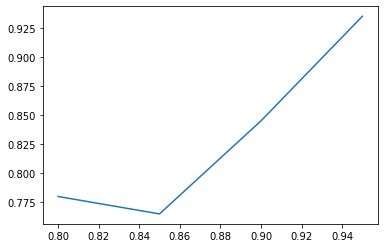

In [ ]:
plt.plot(alpha,[accuracy[0][0],accuracy[1][0],accuracy[2][0],accuracy[3][0]])

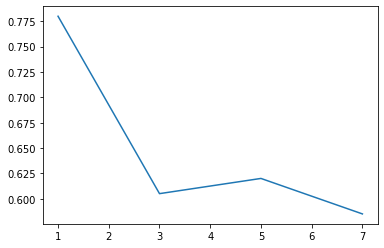

In [ ]:
plt.plot(neighbors,accuracy[0])

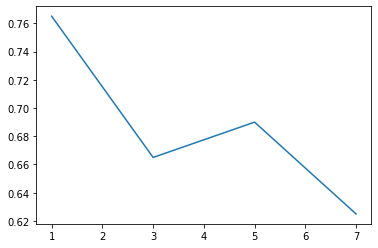

In [ ]:
plt.plot(neighbors,accuracy[1])

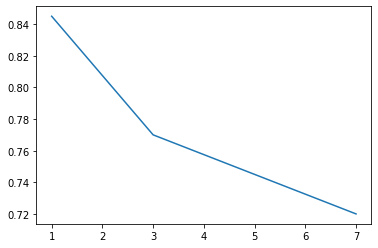

In [ ]:
plt.plot(neighbors,accuracy[2])

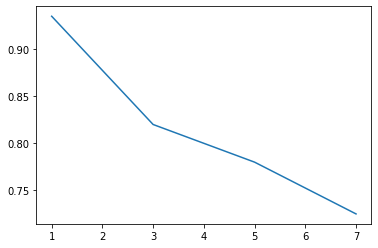

In [ ]:
plt.plot(neighbors,accuracy[3])

## Classification Using LDA

In [ ]:
def LDA(trainSet,means,classes):
  # Compute Means
  for each in classes:
    mean = np.mean(each.values,axis=0)
    means.append(mean)


  totalMean = np.array(trainSet.drop(10304,axis=1)).mean(axis=0)
  totalMean.astype(float)
  Sb = np.zeros((10304,10304))


  # Computer Sb matrix
  for i in range(1,len(means)):
    temp = (np.outer((means[i] - totalMean),np.array(means[i] - totalMean).T))
    Sb = Sb + temp

  Sb = 5 * Sb

  # Compute within class scatter matrix
  Z = []
  for i in range(len(means)):
    temp = classes[i] - means[i].T
    Z.append(temp)

  S = np.zeros((10304,10304))
  for each in Z:
    S = S + np.dot(np.array(each.T),np.array(each))

  # Compute EigenValues and EigenVectors
  matrixEigen = np.linalg.inv(S).dot(Sb)
  vals, vects = np.linalg.eigh(matrixEigen)
  
  return vals,vects


In [ ]:
means = []
classes = []

trainCopy = trainData.copy()
labels = trainCopy[10304].nunique()

# Seperate Classes
for i in range(labels):
  classTemp = trainCopy[trainCopy[10304]==i]
  classTemp = classTemp.drop(10304,axis=1)
  classes.append(classTemp)

vals, vects = LDA(trainCopy,means,classes)

/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:182: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


In [ ]:
# Explained Variance and Projection Matrix Calculations
testCopy = testData.copy()

indices = np.argsort(vals)[::-1]
sortEigVals= vals[indices]
sortEigVect = vects[:,indices]
U = sortEigVect[:,:39]

# Project Training Data
LDATrain = np.dot(trainCopy.drop(10304,axis=1),U)

# Project Test Data
LDATest = np.dot(testCopy.drop(10304,axis=1),U)

# Find accuracy
accuracyLDA = knn(LDATrain,LDATest,trainLabels,testLabels)

Accuracy of LDA = [0.93, 0.84, 0.795, 0.77]


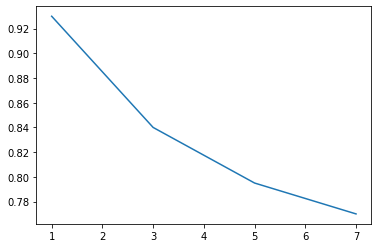

In [ ]:
print(f'Accuracy of LDA = {accuracyLDA}')
plt.plot(neighbors,accuracyLDA)

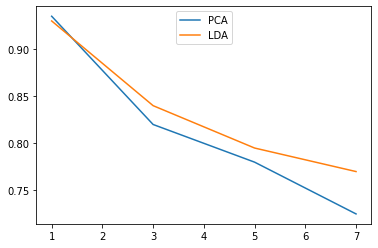

In [ ]:
plt.plot(neighbors,accuracy[3], label = 'PCA')
plt.plot(neighbors,accuracyLDA, label = 'LDA')
plt.legend(loc = 'upper center')

## Bonus: 70-30 Split vs 50-50 split

In [ ]:
from sklearn.model_selection import train_test_split
df1 = df.copy()
bonusLabels = df1[10304]

# Split Data
trainSplit, testSplit, trainLabelSplit, testLabelSplit = train_test_split(df1, bonusLabels, test_size=0.3, random_state=42, stratify = bonusLabels)

PCA

In [ ]:
alpha = [0.95]
trainSCopy = trainSplit.copy()
trainSCopy = trainSCopy.drop(10304,axis=1)

print(trainSCopy.shape)


(280, 10304)


In [ ]:
projectionSplit = PCA(trainSCopy,alpha)

In [ ]:

reducedTrainSplit = []
reducedTestSplit = []

testSCopy = testSplit.copy()
testSCopy = testSCopy.drop(10304,axis=1)

# Project Training Data
for matrix in projectionSplit:
  centeredTrain = trainSCopy - np.mean(trainSCopy,axis=0)
  preDataTrain = np.dot(matrix.transpose(),((centeredTrain.values).transpose()))
  dataTrain = preDataTrain.transpose()
  reducedTrainSplit.append(dataTrain)

  
# Project Test Data
for matrix in projectionSplit:
  centeredTest = testSCopy - np.mean(testSCopy,axis=0)
  preDataTest = np.dot((matrix.transpose()),((centeredTest.values).transpose()))
  dataTest = preDataTest.transpose()
  reducedTestSplit.append(dataTest)

In [ ]:
accuracySplit = []
for i in range(len(reducedTrainSplit)):
  accuracySplit.append(knn(reducedTrainSplit[i],reducedTestSplit[i],trainLabelSplit,testLabelSplit))

### PCA

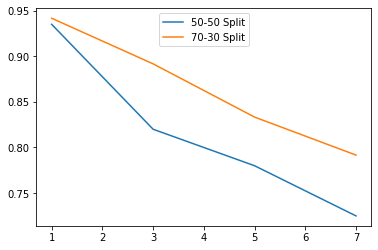

In [ ]:
plt.plot(neighbors,accuracy[3],label = '50-50 Split')
plt.plot(neighbors,accuracySplit[0], label = '70-30 Split')
plt.legend(loc = 'upper center')

LDA

In [ ]:
means = []
classes = []

trainSCopy1 = trainSplit.copy()
labelsSplit = trainSCopy1[10304].nunique()

# Seperate Classes
for i in range(labelsSplit):
  classTemp = trainSCopy1[trainSCopy1[10304]==i]
  classTemp = classTemp.drop(10304,axis=1)
  classes.append(classTemp)

vals, vects = LDA(trainSCopy1,means,classes)

/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:182: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


In [ ]:
# Explained Variance and Projection Matrix Calculations
testSCopy1 = testSplit.copy()

indices = np.argsort(vals)[::-1]
sortEigVals= vals[indices]
sortEigVect = vects[:,indices]
U = sortEigVect[:,:39]

# Project Training Data
LDATrainSplit = np.dot(trainSCopy1.drop(10304,axis=1),U)

# Project Test Data
LDATestSplit = np.dot(testSCopy1.drop(10304,axis=1),U)

# Find accuracy
accuracyLDASplit = knn(LDATrainSplit,LDATestSplit,trainLabelSplit,testLabelSplit)

### LDA

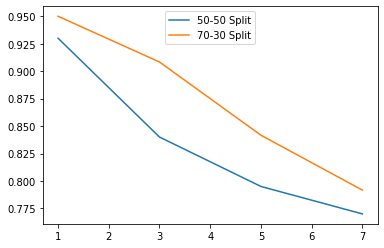

In [ ]:
plt.plot(neighbors,accuracyLDA,label = '50-50 Split')
plt.plot(neighbors,accuracyLDASplit, label = '70-30 Split')
plt.legend(loc = 'upper center')

In [ ]:
print(f'PCA Accuracy 50-50: {accuracy[3]}')
print(f'PCA Accuracy 70-30: {accuracySplit[0]}')

PCA Accuracy 50-50: [0.935, 0.82, 0.78, 0.725]
PCA Accuracy 70-30: [0.9416666666666667, 0.8916666666666667, 0.8333333333333334, 0.7916666666666666]


In [ ]:
print(f'LDA Accuracy 50-50: {accuracyLDA}')
print(f'LDA Accuracy 70-30: {accuracyLDASplit}')

LDA Accuracy 50-50: [0.93, 0.84, 0.795, 0.77]
LDA Accuracy 70-30: [0.95, 0.9083333333333333, 0.8416666666666667, 0.7916666666666666]


## Compare vs Non-Face Images 

## Upload Non-faces Dataset

In [ ]:
col=list(range(0,10305))
dfCola = pd.DataFrame(columns=col)
dfColalength = len(dfCola)
dfCola.head()

,0,1,2,3,4,5,6,7,8,9,...,10295,10296,10297,10298,10299,10300,10301,10302,10303,10304


In [ ]:
dim = (92,112)

for i in range(0,200):
  # Read each image
  img_name = "/content/drive/MyDrive/Datasets/Cocacola/cocacola/{}.jpg".format(i)    
  img = cv2.imread(img_name)
  img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
  img = cv2.resize(img, dim, interpolation = cv2.INTER_AREA)
  img = img.transpose()

  # Unroll image
  img = img.flatten() 
  img = np.append(img,i)
  dfColalength = len(dfCola)
  dfCola.loc[dfColalength] = img

for i in range(0,200):
  # Read each image
  img_name = "/content/drive/MyDrive/Datasets/Cocacola/pepsi/{}.jpg".format(i)    
  img = cv2.imread(img_name)
  img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
  img = cv2.resize(img, dim, interpolation = cv2.INTER_AREA)
  img = img.transpose()

  # Unroll image
  img = img.flatten() 
  img = np.append(img,i)
  dfColalength = len(dfCola)
  dfCola.loc[dfColalength] = img

print(dfCola)


    0     1     2     3     4     5     6     7     8     9      ... 10295  \
0     255   255   255   255   255   255   255   255   255   255  ...   255   
1     246   246   246   246   246   246   246   246   246   246  ...   246   
2     255   255   255   255   255   255   255   255   255   255  ...   255   
3     174   175   172   170   165   162   164   165   167   170  ...    45   
4     225   224   227   228   227   227   226   226   227   228  ...   198   
..    ...   ...   ...   ...   ...   ...   ...   ...   ...   ...  ...   ...   
395   254   254   254   254   254   254   254   254   254   254  ...   254   
396    40    32    39    86   159   178   154   115    86    71  ...    66   
397   255   255   255   255   255   255   255   255   255   255  ...   255   
398   247   247   247   247   247   247   247   247   247   247  ...   247   
399   173   171   169   168   166   164   163   161   159   157  ...     0   

    10296 10297 10298 10299 10300 10301 10302 10303 10304  
0  

In [ ]:
# Data as float
dfCola = dfCola.astype(float)
print(dfCola.shape)
dfCola[10304] = dfCola[10304].astype(int)
dfCola[10304].values[:] = 0

dfCola.head()

(400, 10305)


,0,1,2,3,4,5,6,7,8,9,...,10295,10296,10297,10298,10299,10300,10301,10302,10303,10304
0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,...,255.0,198.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0
1,246.0,246.0,246.0,246.0,246.0,246.0,246.0,246.0,246.0,246.0,...,246.0,246.0,246.0,246.0,246.0,246.0,246.0,246.0,246.0,0
2,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,...,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,0
3,174.0,175.0,172.0,170.0,165.0,162.0,164.0,165.0,167.0,170.0,...,45.0,47.0,43.0,43.0,43.0,50.0,53.0,54.0,51.0,0
4,225.0,224.0,227.0,228.0,227.0,227.0,226.0,226.0,227.0,228.0,...,198.0,200.0,105.0,50.0,50.0,50.0,50.0,50.0,50.0,0


In [ ]:
# Split Data
thirtyDf = dfCola.iloc [:120, :] 
halfDf = dfCola.iloc[:200, :]
seventyDf = dfCola.iloc[:280, :]


faces = df.copy()
faces[10304].values[:] = 1

halfFaces = faces.iloc[:200,:]

thirtySeventy = pd.concat([thirtyDf,halfFaces])
halfHalf = pd.concat([halfDf,halfFaces])
seventyThirty = pd.concat([seventyDf,halfFaces])

thirtySeventyLabel = thirtySeventy[10304]
thirtySeventy, thirtySeventyLabel = shuffle(thirtySeventy, thirtySeventyLabel)

halfHalfLabel = halfHalf[10304]
halfHalf, halfHalfLabel = shuffle(halfHalf, halfHalfLabel)

seventyThirtyLabel = seventyThirty[10304]
seventyThirty, seventyThirtyLabel = shuffle(seventyThirty, seventyThirtyLabel)


## Split into Training and Testing Data

 120 Non-Faces, 200 Faces

In [ ]:
# Split Data
thirtyTrain, thirtyTest, thirtyTrainLabel, thirtyTestLabel = train_test_split(thirtySeventy, thirtySeventyLabel, test_size=0.5, random_state=42, stratify = thirtySeventyLabel)

# Shuffle data
thirtyTest, thirtyTestLabel = shuffle(thirtyTest, thirtyTestLabel)
thirtyTrain, thirtyTrainLabel = shuffle(thirtyTrain, thirtyTrainLabel)


PCA

In [ ]:
def failSuccess(data,label,test,testlabel):
  kn = KNeighborsClassifier(n_neighbors=1)

  for i in range(len(data)):
    print(f'----------------- For alpha = {alpha[i]} -----------------')
    kn.fit(data[i],label)
    y_pred = kn.predict(test[i])
    y_pred = y_pred.tolist()
    lb = testlabel.tolist()
    print(f'-----------------Accuracy = {accuracy_score(testlabel,y_pred)} -----------------')
    for i in range(0, len(y_pred)):
      if y_pred[i] == lb[i]:
        print('Correctly classified, labeled as {}'.format(lb[i]))
      else:
        print('{} is misclassified as {}'.format(lb[i],y_pred[i]))
    print('')
    print('')

In [ ]:
alpha = [0.8,0.85,0.9,0.95]
trainCopy = thirtyTrain.copy()
trainCopy = trainCopy.drop(10304,axis=1)
projectionMatrix = PCA(trainCopy,alpha)

In [ ]:
print(projectionMatrix[0].shape,projectionMatrix[1].shape,projectionMatrix[2].shape,projectionMatrix[3].shape)

(10304, 13) (10304, 21) (10304, 35) (10304, 63)


In [ ]:
reducedTrain = []
reducedTest = []
testCopy = thirtyTest.copy()
testCopy = testCopy.drop(10304,axis=1)


# Project Training Data
for matrix in projectionMatrix:
  centeredTrain = trainCopy - np.mean(trainCopy,axis=0)
  preDataTrain = np.dot(matrix.transpose(),((centeredTrain.values).transpose()))
  dataTrain = preDataTrain.transpose()
  reducedTrain.append(dataTrain)

  
# Project Test Data
for matrix in projectionMatrix:
  centeredTest = testCopy - np.mean(testCopy,axis=0)
  preDataTest = np.dot((matrix.transpose()),((centeredTest.values).transpose()))
  dataTest = preDataTest.transpose()
  reducedTest.append(dataTest)


In [ ]:
neighbors = [1]
accuracyNonFaces = []
for i in range(len(reducedTrain)):
  accuracyNonFaces.append(knn(reducedTrain[i],reducedTest[i],thirtyTrainLabel,thirtyTestLabel))

### PCA

Accuracy for aplha = 0.8 Accuracy = [0.9375]
Accuracy for aplha = 0.85 Accuracy = [0.925]
Accuracy for aplha = 0.9 Accuracy = [0.93125]
Accuracy for aplha = 0.95 Accuracy = [0.95]


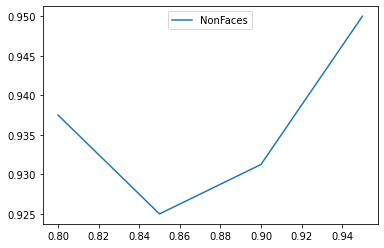

In [ ]:
for i in range(len(accuracyNonFaces)):
  print(f'Accuracy for aplha = {alpha[i]} Accuracy = {accuracyNonFaces[i]}')

plt.plot(alpha,[accuracyNonFaces[0][0],accuracyNonFaces[1][0],accuracyNonFaces[2][0],accuracyNonFaces[3][0]], label = 'NonFaces')
plt.legend(loc = 'upper center')

In [ ]:
failSuccess(reducedTrain,thirtyTrainLabel,reducedTest,thirtyTestLabel)

----------------- For alpha = 0.8 -----------------
-----------------Accuracy = 0.9375 -----------------
Correctly classified, labeled as 1
Correctly classified, labeled as 1
Correctly classified, labeled as 1
Correctly classified, labeled as 1
Correctly classified, labeled as 0
Correctly classified, labeled as 0
Correctly classified, labeled as 1
Correctly classified, labeled as 1
Correctly classified, labeled as 1
0 is misclassified as 1
Correctly classified, labeled as 1
Correctly classified, labeled as 1
Correctly classified, labeled as 1
Correctly classified, labeled as 1
Correctly classified, labeled as 0
Correctly classified, labeled as 1
Correctly classified, labeled as 1
Correctly classified, labeled as 1
Correctly classified, labeled as 1
Correctly classified, labeled as 0
Correctly classified, labeled as 1
Correctly classified, labeled as 0
Correctly classified, labeled as 1
Correctly classified, labeled as 0
Correctly classified, labeled as 1
Correctly classified, labeled a

LDA

In [ ]:
means = []
classes = []

trainCopy = thirtyTrain.copy()
labels = trainCopy[10304].nunique()

# Seperate Classes
for i in range(labels):
  classTemp = trainCopy[trainCopy[10304]==i]
  classTemp = classTemp.drop(10304,axis=1)
  classes.append(classTemp)

vals, vects = LDA(trainCopy,means,classes)

In [ ]:
# Explained Variance and Projection Matrix Calculations
testCopy = thirtyTest.copy()

indices = np.argsort(vals)[::-1]
sortEigVals= vals[indices]
sortEigVect = vects[:,indices]

U = []
U.append(sortEigVect[:,:2])
U.append(sortEigVect[:,:17])
U.append(sortEigVect[:,:34])
U.append(sortEigVect[:,:60])

# Project Training Data
LDATrainThirty = []
LDATestThirty = []

for each in U:
  LDATrainThirty.append(np.dot(trainCopy.drop(10304,axis=1),each))

# Project Test Data
  LDATestThirty.append(np.dot(testCopy.drop(10304,axis=1),each))

accuracyLDAThirty = []
# Find accuracy
for i in range(len(LDATrainThirty)):
  accuracyLDAThirty.append(knn(LDATrainThirty[i],LDATestThirty[i],thirtyTrainLabel,thirtyTestLabel))

### LDA

Accuracy for aplha = 0.8 Accuracy = [0.9]
Accuracy for aplha = 0.85 Accuracy = [0.9625]
Accuracy for aplha = 0.9 Accuracy = [0.98125]
Accuracy for aplha = 0.95 Accuracy = [0.9875]


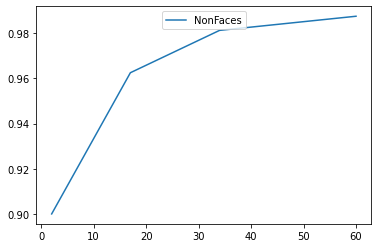

In [ ]:
for i in range(len(accuracyLDAThirty)):
  print(f'Accuracy for aplha = {alpha[i]} Accuracy = {accuracyLDAThirty[i]}')

ev = [2,17,34,60]
plt.plot(ev,[accuracyLDAThirty[0][0],accuracyLDAThirty[1][0],accuracyLDAThirty[2][0],accuracyLDAThirty[3][0]], label = 'NonFaces')
plt.legend(loc = 'upper center')

In [ ]:
failSuccess(LDATrainThirty, thirtyTrainLabel, LDATestThirty, thirtyTestLabel)

----------------- For alpha = 0.8 -----------------
-----------------Accuracy = 0.9 -----------------
Correctly classified, labeled as 1
Correctly classified, labeled as 1
Correctly classified, labeled as 1
Correctly classified, labeled as 1
Correctly classified, labeled as 0
Correctly classified, labeled as 0
Correctly classified, labeled as 1
Correctly classified, labeled as 1
Correctly classified, labeled as 1
0 is misclassified as 1
Correctly classified, labeled as 1
1 is misclassified as 0
Correctly classified, labeled as 1
Correctly classified, labeled as 1
Correctly classified, labeled as 0
Correctly classified, labeled as 1
Correctly classified, labeled as 1
Correctly classified, labeled as 1
Correctly classified, labeled as 1
Correctly classified, labeled as 0
Correctly classified, labeled as 1
Correctly classified, labeled as 0
1 is misclassified as 0
Correctly classified, labeled as 0
Correctly classified, labeled as 1
Correctly classified, labeled as 1
Correctly classified,

200 Faces, 200 Non-faces

In [ ]:
# Split Data
halfTrain, halfTest, halfTrainLabel, halfTestLabel = train_test_split(halfHalf, halfHalfLabel, test_size=0.5, random_state=42, stratify = halfHalfLabel)

# Shuffle data
halfTest, halfTestLabel = shuffle(halfTest, halfTestLabel)
halfTrain, halfTrainLabel = shuffle(halfTrain, halfTrainLabel)

PCA

In [ ]:
trainCopy = halfTrain.copy()
trainCopy = trainCopy.drop(10304,axis=1)
projectionMatrix = PCA(trainCopy,alpha)

In [ ]:
print(projectionMatrix[0].shape,projectionMatrix[1].shape,projectionMatrix[2].shape,projectionMatrix[3].shape)

(10304, 10) (10304, 18) (10304, 34) (10304, 69)


In [ ]:
reducedTrain = []
reducedTest = []
testCopy = halfTest.copy()
testCopy = testCopy.drop(10304,axis=1)


# Project Training Data
for matrix in projectionMatrix:
  centeredTrain = trainCopy - np.mean(trainCopy,axis=0)
  preDataTrain = np.dot(matrix.transpose(),((centeredTrain.values).transpose()))
  dataTrain = preDataTrain.transpose()
  reducedTrain.append(dataTrain)

  
# Project Test Data
for matrix in projectionMatrix:
  centeredTest = testCopy - np.mean(testCopy,axis=0)
  preDataTest = np.dot((matrix.transpose()),((centeredTest.values).transpose()))
  dataTest = preDataTest.transpose()
  reducedTest.append(dataTest)


### PCA

Accuracy for aplha = 0.8 Accuracy = [0.88]
Accuracy for aplha = 0.85 Accuracy = [0.895]
Accuracy for aplha = 0.9 Accuracy = [0.955]
Accuracy for aplha = 0.95 Accuracy = [0.93]


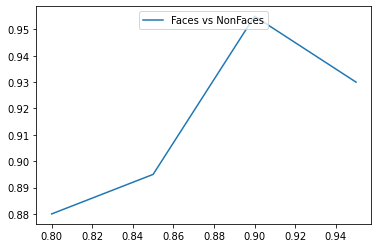

In [ ]:
accuracyNonFaces1 = []
for i in range(len(reducedTrain)):
  accuracyNonFaces1.append(knn(reducedTrain[i],reducedTest[i],halfTrainLabel,halfTestLabel))

for i in range(len(accuracyNonFaces1)):
  print(f'Accuracy for aplha = {alpha[i]} Accuracy = {accuracyNonFaces1[i]}')

plt.plot(alpha,[accuracyNonFaces1[0][0],accuracyNonFaces1[1][0],accuracyNonFaces1[2][0],accuracyNonFaces1[3][0]], label = 'Faces vs NonFaces')
plt.legend(loc = 'upper center')


In [ ]:
failSuccess(reducedTrain,halfTrainLabel,reducedTest,halfTestLabel)

----------------- For alpha = 0.8 -----------------
-----------------Accuracy = 0.88 -----------------
Correctly classified, labeled as 0
Correctly classified, labeled as 1
Correctly classified, labeled as 0
Correctly classified, labeled as 0
Correctly classified, labeled as 0
Correctly classified, labeled as 1
Correctly classified, labeled as 1
Correctly classified, labeled as 0
Correctly classified, labeled as 1
Correctly classified, labeled as 1
0 is misclassified as 1
0 is misclassified as 1
Correctly classified, labeled as 0
Correctly classified, labeled as 0
0 is misclassified as 1
Correctly classified, labeled as 1
Correctly classified, labeled as 1
Correctly classified, labeled as 0
Correctly classified, labeled as 1
Correctly classified, labeled as 1
Correctly classified, labeled as 1
Correctly classified, labeled as 1
Correctly classified, labeled as 1
Correctly classified, labeled as 0
Correctly classified, labeled as 1
Correctly classified, labeled as 0
Correctly classified

LDA

In [ ]:
means = []
classes = []

trainCopy = halfTrain.copy()
labels = trainCopy[10304].nunique()

# Seperate Classes
for i in range(labels):
  classTemp = trainCopy[trainCopy[10304]==i]
  classTemp = classTemp.drop(10304,axis=1)
  classes.append(classTemp)

vals, vects = LDA(trainCopy,means,classes)

In [ ]:
# Explained Variance and Projection Matrix Calculations
testCopy = halfTest.copy()

indices = np.argsort(vals)[::-1]
sortEigVals= vals[indices]
sortEigVect = vects[:,indices]

U = []
U.append(sortEigVect[:,:10])
U.append(sortEigVect[:,:18])
U.append(sortEigVect[:,:34])
U.append(sortEigVect[:,:69])

# Project Training Data
LDATrainHalf = []
LDATestHalf = []

for each in U:
  LDATrainHalf.append(np.dot(trainCopy.drop(10304,axis=1),each))

# Project Test Data
  LDATestHalf.append(np.dot(testCopy.drop(10304,axis=1),each))

accuracyLDAHalf = []
# Find accuracy
for i in range(len(LDATrainHalf)):
  accuracyLDAHalf.append(knn(LDATrainHalf[i],LDATestHalf[i],halfTrainLabel,halfTestLabel))

### LDA

Number of EgienVectors = 10 Accuracy = [0.93]
Number of EgienVectors = 18 Accuracy = [0.96]
Number of EgienVectors = 34 Accuracy = [0.95]
Number of EgienVectors = 69 Accuracy = [0.97]


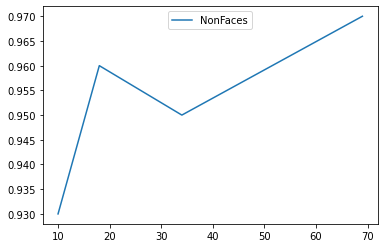

In [ ]:
ev = [10,18,34,69]
for i in range(len(accuracyLDAHalf)):
  print(f'Number of EgienVectors = {ev[i]} Accuracy = {accuracyLDAHalf[i]}')

plt.plot(ev,[accuracyLDAHalf[0][0],accuracyLDAHalf[1][0],accuracyLDAHalf[2][0],accuracyLDAHalf[3][0]], label = 'NonFaces')
plt.legend(loc = 'upper center')

280 Non-faces, 200 Faces

In [ ]:
# Split Data
seventyTrain, seventyTest, seventyTrainLabel, seventyTestLabel = train_test_split(seventyThirty, seventyThirtyLabel, test_size=0.5, random_state=42, stratify = seventyThirtyLabel)

# Shuffle data
seventyTest, seventyTestLabel = shuffle(seventyTest, seventyTestLabel)
seventyTrain, seventyTrainLabel = shuffle(seventyTrain, seventyTrainLabel)

PCA

In [ ]:
trainCopy = seventyTrain.copy()
trainCopy = trainCopy.drop(10304,axis=1)
projectionMatrix = PCA(trainCopy,alpha)

In [ ]:
print(projectionMatrix[0].shape,projectionMatrix[1].shape,projectionMatrix[2].shape,projectionMatrix[3].shape)

(10304, 12) (10304, 23) (10304, 42) (10304, 83)


In [ ]:
reducedTrain = []
reducedTest = []
testCopy = seventyTest.copy()
testCopy = testCopy.drop(10304,axis=1)


# Project Training Data
for matrix in projectionMatrix:
  centeredTrain = trainCopy - np.mean(trainCopy,axis=0)
  preDataTrain = np.dot(matrix.transpose(),((centeredTrain.values).transpose()))
  dataTrain = preDataTrain.transpose()
  reducedTrain.append(dataTrain)

  
# Project Test Data
for matrix in projectionMatrix:
  centeredTest = testCopy - np.mean(testCopy,axis=0)
  preDataTest = np.dot((matrix.transpose()),((centeredTest.values).transpose()))
  dataTest = preDataTest.transpose()
  reducedTest.append(dataTest)

### PCA

Accuracy for aplha = 0.8 Accuracy = [0.8833333333333333]
Accuracy for aplha = 0.85 Accuracy = [0.8916666666666667]
Accuracy for aplha = 0.9 Accuracy = [0.925]
Accuracy for aplha = 0.95 Accuracy = [0.9708333333333333]


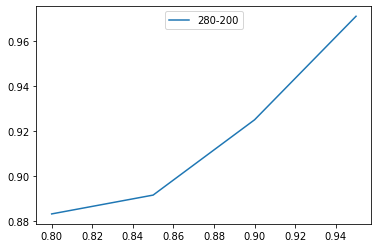

In [ ]:
neighbors = [1]
accuracyNonFaces2 = []
for i in range(len(reducedTrain)):
  accuracyNonFaces2.append(knn(reducedTrain[i],reducedTest[i],seventyTrainLabel,seventyTestLabel))

for i in range(len(accuracyNonFaces2)):
  print(f'Accuracy for aplha = {alpha[i]} Accuracy = {accuracyNonFaces2[i]}')

plt.plot(alpha,[accuracyNonFaces2[0][0],accuracyNonFaces2[1][0],accuracyNonFaces2[2][0],accuracyNonFaces2[3][0]], label = '280-200')
plt.legend(loc = 'upper center')

In [ ]:
failSuccess(reducedTrain,seventyTrainLabel,reducedTest,seventyTestLabel)

----------------- For alpha = 0.8 -----------------
-----------------Accuracy = 0.8833333333333333 -----------------
Correctly classified, labeled as 0
Correctly classified, labeled as 1
Correctly classified, labeled as 0
Correctly classified, labeled as 1
Correctly classified, labeled as 0
Correctly classified, labeled as 0
Correctly classified, labeled as 0
0 is misclassified as 1
Correctly classified, labeled as 1
1 is misclassified as 0
Correctly classified, labeled as 1
Correctly classified, labeled as 1
1 is misclassified as 0
0 is misclassified as 1
Correctly classified, labeled as 1
Correctly classified, labeled as 0
Correctly classified, labeled as 0
0 is misclassified as 1
Correctly classified, labeled as 1
Correctly classified, labeled as 0
Correctly classified, labeled as 1
Correctly classified, labeled as 0
Correctly classified, labeled as 1
Correctly classified, labeled as 1
Correctly classified, labeled as 1
Correctly classified, labeled as 1
Correctly classified, labele

LDA

In [ ]:
means = []
classes = []

trainCopy = seventyTrain.copy()
labels = trainCopy[10304].nunique()

# Seperate Classes
for i in range(labels):
  classTemp = trainCopy[trainCopy[10304]==i]
  classTemp = classTemp.drop(10304,axis=1)
  classes.append(classTemp)

vals, vects = LDA(trainCopy,means,classes)

In [ ]:
# Explained Variance and Projection Matrix Calculations
testCopy = seventyTest.copy()

indices = np.argsort(vals)[::-1]
sortEigVals= vals[indices]
sortEigVect = vects[:,indices]


U = []
U.append(sortEigVect[:,:12])
U.append(sortEigVect[:,:23])
U.append(sortEigVect[:,:42])
U.append(sortEigVect[:,:83])

# Project Training Data
LDATrainSeventy = []
LDATestSeventy = []

for each in U:
  LDATrainSeventy.append(np.dot(trainCopy.drop(10304,axis=1),each))

# Project Test Data
  LDATestSeventy.append(np.dot(testCopy.drop(10304,axis=1),each))

accuracyLDASeventy = []
# Find accuracy
for i in range(len(LDATrainSeventy)):
  accuracyLDASeventy.append(knn(LDATrainSeventy[i],LDATestSeventy[i],seventyTrainLabel,seventyTestLabel))

### LDA

Number of EgienVectors = 12 Accuracy = [0.9541666666666667]
Number of EgienVectors = 23 Accuracy = [0.975]
Number of EgienVectors = 42 Accuracy = [0.9833333333333333]
Number of EgienVectors = 83 Accuracy = [0.975]


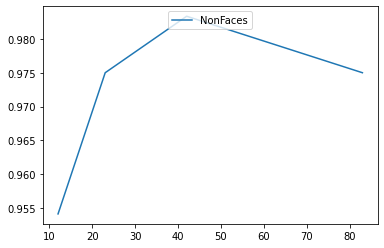

In [ ]:
ev = [12,23,42,83]
for i in range(len(accuracyLDASeventy)):
  print(f'Number of EgienVectors = {ev[i]} Accuracy = {accuracyLDASeventy[i]}')

plt.plot(ev,[accuracyLDASeventy[0][0],accuracyLDASeventy[1][0],accuracyLDASeventy[2][0],accuracyLDASeventy[3][0]], label = 'NonFaces')
plt.legend(loc = 'upper center')

350 Non-faces, 200 Faces

In [ ]:
fiftyDf = dfCola.iloc[:350, :]

fifty = pd.concat([fiftyDf, halfFaces])
fiftyLabels = fifty[10304]

fifty, fiftyLabels = shuffle(fifty,fiftyLabels)

In [ ]:
# Split Data
fiftyTrain, fiftyTest, fiftyTrainLabel, fiftyTestLabel = train_test_split(fifty, fiftyLabels, test_size=0.5, random_state=42, stratify = fiftyLabels)

# Shuffle data
fiftyTest, fiftyTestLabel = shuffle(fiftyTest, fiftyTestLabel)
fiftyTrain, fiftyTrainLabel = shuffle(fiftyTrain, fiftyTrainLabel)

In [ ]:
trainCopy = fiftyTrain.copy()
trainCopy = trainCopy.drop(10304,axis=1)
projectionMatrix = PCA(trainCopy,alpha)

In [ ]:
print(projectionMatrix[0].shape,projectionMatrix[1].shape,projectionMatrix[2].shape,projectionMatrix[3].shape)

(10304, 11) (10304, 22) (10304, 43) (10304, 88)


In [ ]:
reducedTrain = []
reducedTest = []
testCopy = fiftyTest.copy()
testCopy = testCopy.drop(10304,axis=1)


# Project Training Data
for matrix in projectionMatrix:
  centeredTrain = trainCopy - np.mean(trainCopy,axis=0)
  preDataTrain = np.dot(matrix.transpose(),((centeredTrain.values).transpose()))
  dataTrain = preDataTrain.transpose()
  reducedTrain.append(dataTrain)

  
# Project Test Data
for matrix in projectionMatrix:
  centeredTest = testCopy - np.mean(testCopy,axis=0)
  preDataTest = np.dot((matrix.transpose()),((centeredTest.values).transpose()))
  dataTest = preDataTest.transpose()
  reducedTest.append(dataTest)

Accuracy for aplha = 0.8 Accuracy = [0.8618181818181818]
Accuracy for aplha = 0.85 Accuracy = [0.9236363636363636]
Accuracy for aplha = 0.9 Accuracy = [0.9345454545454546]
Accuracy for aplha = 0.95 Accuracy = [0.9672727272727273]


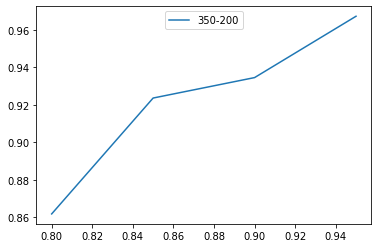

In [ ]:
neighbors = [1]
accuracyNonFaces3 = []
for i in range(len(reducedTrain)):
  accuracyNonFaces3.append(knn(reducedTrain[i],reducedTest[i],fiftyTrainLabel,fiftyTestLabel))

for i in range(len(accuracyNonFaces3)):
  print(f'Accuracy for aplha = {alpha[i]} Accuracy = {accuracyNonFaces3[i]}')

plt.plot(alpha,[accuracyNonFaces3[0][0],accuracyNonFaces3[1][0],accuracyNonFaces3[2][0],accuracyNonFaces3[3][0]], label = '350-200')
plt.legend(loc = 'upper center')

In [ ]:
failSuccess(reducedTrain,fiftyTrainLabel,reducedTest,fiftyTestLabel)

----------------- For alpha = 0.8 -----------------
-----------------Accuracy = 0.8618181818181818 -----------------
Correctly classified, labeled as 0
Correctly classified, labeled as 0
Correctly classified, labeled as 0
Correctly classified, labeled as 0
1 is misclassified as 0
Correctly classified, labeled as 0
Correctly classified, labeled as 0
Correctly classified, labeled as 0
Correctly classified, labeled as 0
Correctly classified, labeled as 0
Correctly classified, labeled as 0
Correctly classified, labeled as 0
Correctly classified, labeled as 0
Correctly classified, labeled as 0
Correctly classified, labeled as 1
Correctly classified, labeled as 1
Correctly classified, labeled as 1
Correctly classified, labeled as 0
Correctly classified, labeled as 0
0 is misclassified as 1
Correctly classified, labeled as 0
Correctly classified, labeled as 1
Correctly classified, labeled as 0
Correctly classified, labeled as 0
Correctly classified, labeled as 1
Correctly classified, labeled 

LDA

In [ ]:
means = []
classes = []

trainCopy = fiftyTrain.copy()
labels = trainCopy[10304].nunique()

# Seperate Classes
for i in range(labels):
  classTemp = trainCopy[trainCopy[10304]==i]
  classTemp = classTemp.drop(10304,axis=1)
  classes.append(classTemp)

vals, vects = LDA(trainCopy,means,classes)

In [ ]:
# Explained Variance and Projection Matrix Calculations
testCopy = fiftyTest.copy()

indices = np.argsort(vals)[::-1]
sortEigVals= vals[indices]
sortEigVect = vects[:,indices]

U = []
U.append(sortEigVect[:,:11])
U.append(sortEigVect[:,:22])
U.append(sortEigVect[:,:43])
U.append(sortEigVect[:,:88])

# Project Training Data
LDATrainFifty = []
LDATestFifty = []

for each in U:
  LDATrainFifty.append(np.dot(trainCopy.drop(10304,axis=1),each))

# Project Test Data
  LDATestFifty.append(np.dot(testCopy.drop(10304,axis=1),each))

accuracyLDAFifty = []
# Find accuracy
for i in range(len(LDATrainFifty)):
  accuracyLDAFifty.append(knn(LDATrainFifty[i],LDATestFifty[i],fiftyTrainLabel,fiftyTestLabel))

Number of EgienVectors = 11 Accuracy = [0.9636363636363636]
Number of EgienVectors = 22 Accuracy = [0.9527272727272728]
Number of EgienVectors = 43 Accuracy = [0.9781818181818182]
Number of EgienVectors = 88 Accuracy = [0.9709090909090909]


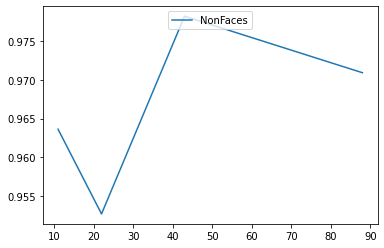

In [ ]:
ev = [11,22,43,88]
for i in range(len(accuracyLDAFifty)):
  print(f'Number of EgienVectors = {ev[i]} Accuracy = {accuracyLDAFifty[i]}')

plt.plot(ev,[accuracyLDAFifty[0][0],accuracyLDAFifty[1][0],accuracyLDAFifty[2][0],accuracyLDAFifty[3][0]], label = 'NonFaces')
plt.legend(loc = 'upper center')

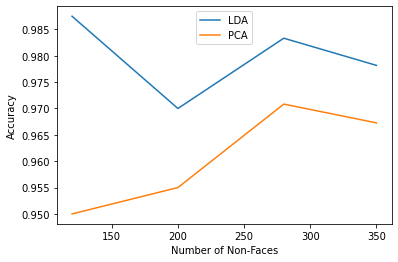

In [ ]:
plt.plot([120,200,280,350],[accuracyLDAThirty[3][0],accuracyLDAHalf[3][0],accuracyLDASeventy[2][0],accuracyLDAFifty[2][0]],label ='LDA')
plt.plot([120,200,280,350],[accuracyNonFaces[3][0],accuracyNonFaces1[2][0],accuracyNonFaces2[3][0],accuracyNonFaces3[3][0]], label = 'PCA')
plt.xlabel("Number of Non-Faces")
plt.ylabel("Accuracy")
plt.legend(loc = 'upper center')